# Prerequisites (installing libraries)

In [0]:
from IPython import display
from __future__ import print_function
!pip install tensorflow-serving-api
!pip install ratelimiter
!pip install pillow
!pip install grpcio
display.clear_output()

## Import

In [0]:
import io
import time
import grpc

import numpy as np
from matplotlib.pylab import plt

from PIL import Image,ImageDraw
import tensorflow as tf
import matplotlib.pyplot

from tensorflow_serving.apis import predict_pb2
from tensorflow_serving.apis import prediction_service_pb2_grpc

# Prepares inference GRPC requests

## Creates gRPC stub

In [0]:
tpu_path = "grpc://35.222.74.109:80" #@param
tpu_address = tf.contrib.cluster_resolver.TPUClusterResolver(
    tpu_path).master()
if 'grpc://' in tpu_address:
  tpu_address = tpu_address[len('grpc://'):]
tf.logging.info('ModelServer at: {}'.format(tpu_address))
grpc_channel = grpc.insecure_channel(tpu_address)
stub = prediction_service_pb2_grpc.PredictionServiceStub(grpc_channel)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:ModelServer at: 35.222.74.109:80


## Helper functions to generate gRPC requests and make gRPC call

In [0]:
def generate_request(image, model_name):
  """Generate inference request with payload."""
  request = predict_pb2.PredictRequest()
  request.model_spec.name = model_name
  request.model_spec.signature_name = 'serving_default'
  request.inputs['input'].CopyFrom(
      tf.contrib.util.make_tensor_proto([image]))
  return request

def run_detection(request, stub, request_timeout=300.0, print_response=False):
  start_time = time.time()
  response = stub.Predict(request, request_timeout)
  end_time = time.time()
  tf.logging.info('gRPC spent {} seconds'.format(end_time - start_time))
  if print_response:
    tf.logging.info('Raw gRPC response: %s' % response)
  detection_boxes = tf.contrib.util.make_ndarray(response.outputs['detection_boxes'])
  detection_classes = tf.contrib.util.make_ndarray(response.outputs['detection_classes'])
  detection_scores = tf.contrib.util.make_ndarray(response.outputs['detection_scores'])
  num_detections = tf.contrib.util.make_ndarray(response.outputs['num_detections'])
  image_info = tf.contrib.util.make_ndarray(response.outputs['image_info'])

  return detection_boxes, detection_scores, detection_classes, num_detections, image_info

## Download a image for detection

--2019-03-29 02:10:38--  https://upload.wikimedia.org/wikipedia/commons/thumb/0/08/Kitano_Street_Kobe01s5s4110.jpg/2560px-Kitano_Street_Kobe01s5s4110.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1360583 (1.3M) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]   1.30M  --.-KB/s    in 0.1s    

2019-03-29 02:10:39 (13.3 MB/s) - ‘test.jpg’ saved [1360583/1360583]

INFO:tensorflow:Reading image: test.jpg


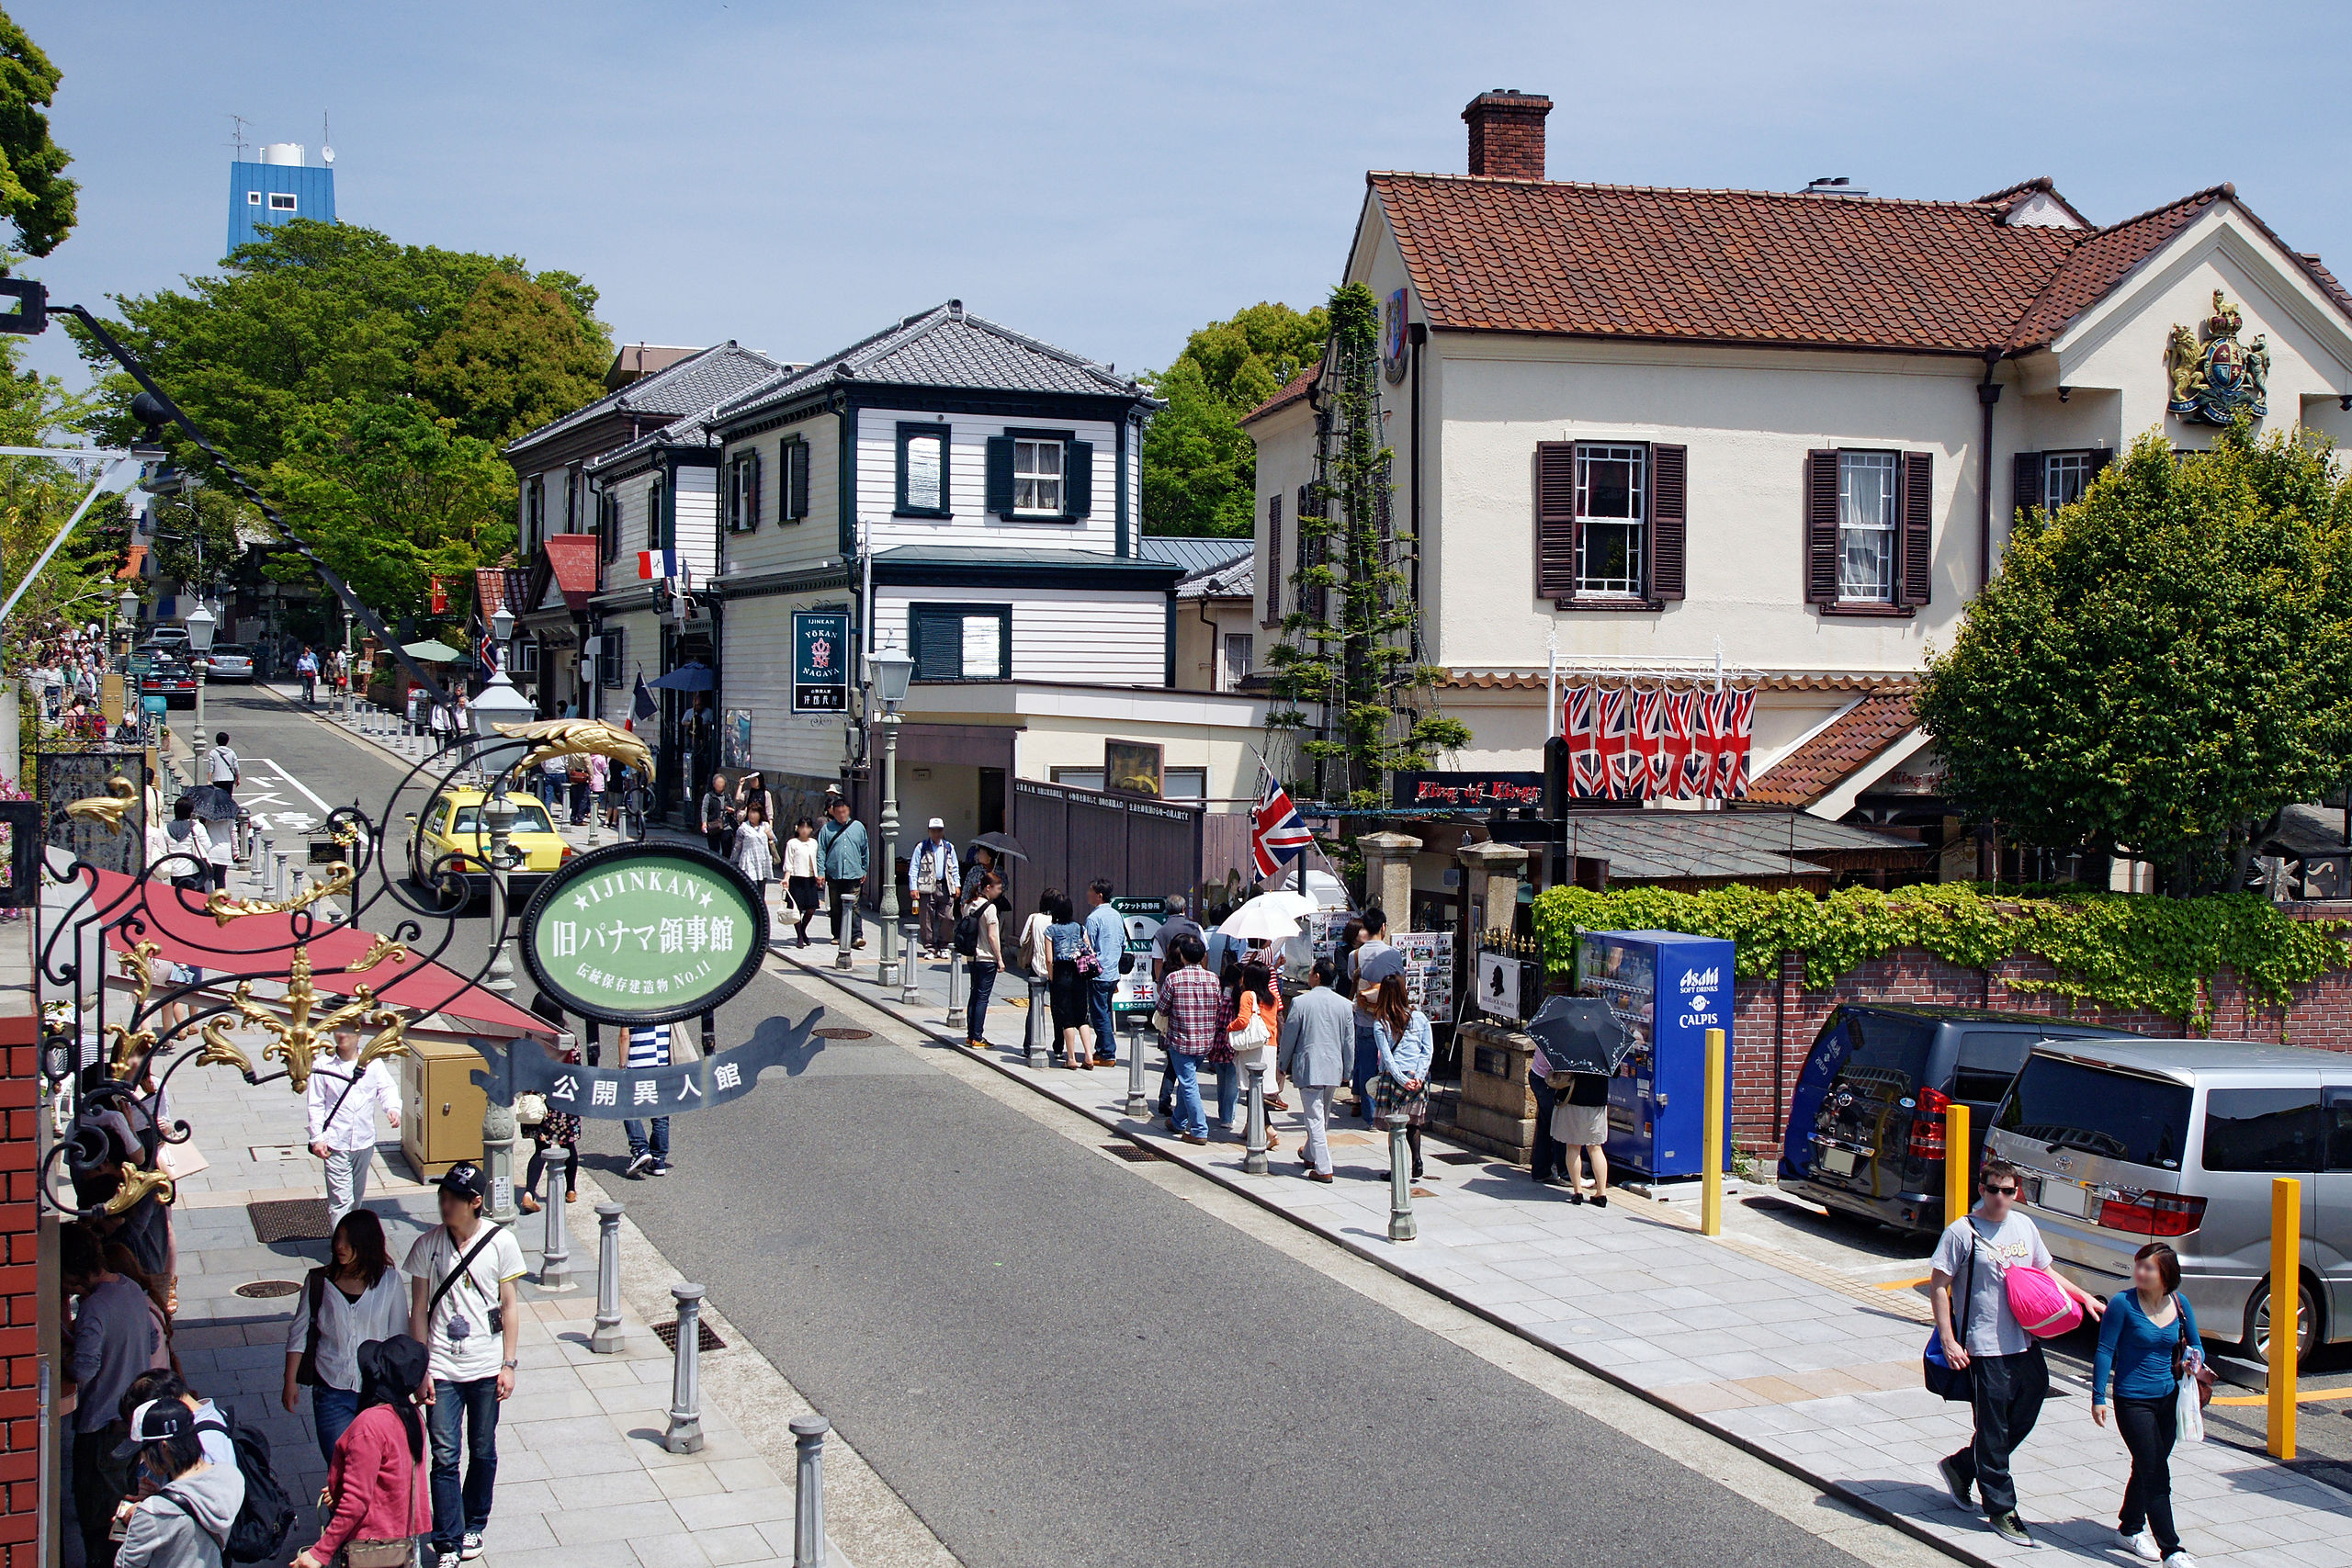

In [0]:
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/0/08/Kitano_Street_Kobe01s5s4110.jpg/2560px-Kitano_Street_Kobe01s5s4110.jpg -O test.jpg
image_path = 'test.jpg'
tf.logging.info('Reading image: {}'.format(image_path))
display.display(display.Image(image_path))

# Makes inference requests to your Cloud TPU server and visualize results

INFO:tensorflow:gRPC spent 1.0098307132720947 seconds


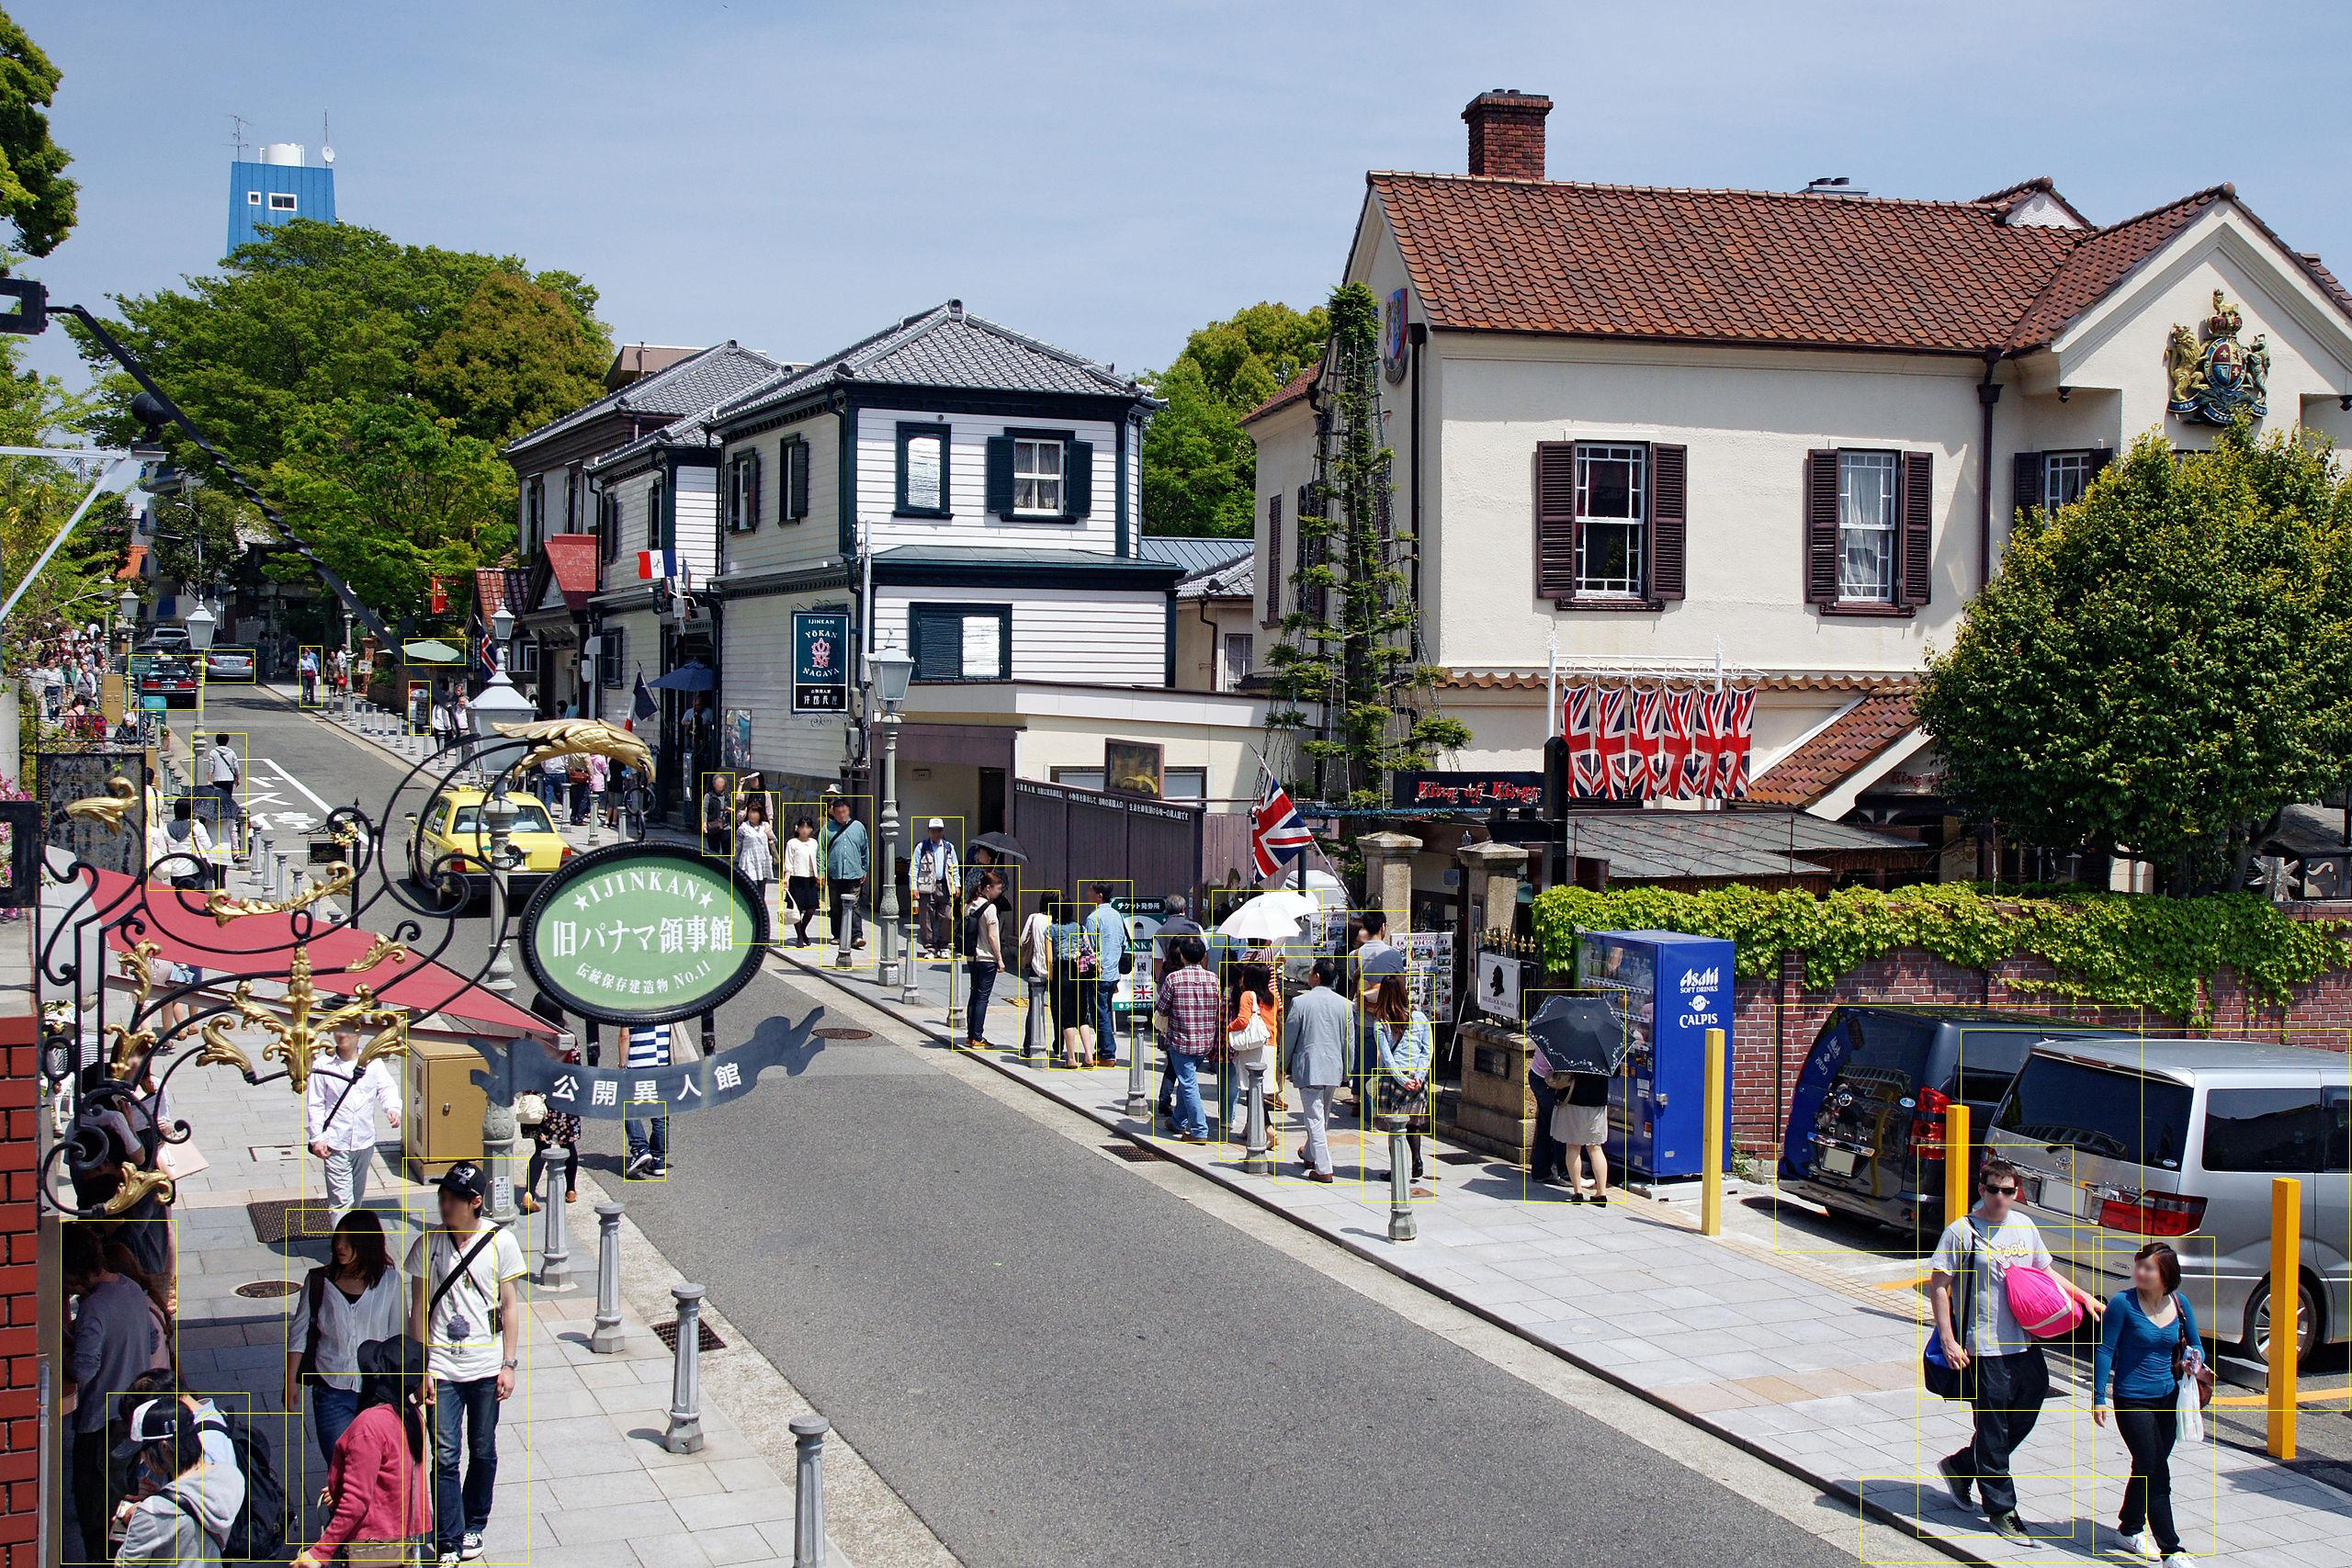

In [0]:
import matplotlib.pyplot as plt
from matplotlib import patches

image_bytes = open(image_path, 'rb').read()
request = generate_request(image_bytes, model_name="saved_model")
boxes, scores, classes, num_detections, image_info = map(lambda arr: arr[0],
                                             run_detection(request, stub))
scale = image_info[2]

# Visuliaze boxes
img = Image.open(image_path)
draw = ImageDraw.Draw(img)
for i in range(boxes.shape[0]):
  if (scores[i] < 0.4):
    continue
  y0, x0, y1, x1 = map(lambda x: x*scale, boxes[i])
  rect = draw.rectangle([x0, y0, x1, y1], outline='yellow')

img.save('detection_result.jpg')
display.display(display.Image('detection_result.jpg'))
